In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0-dev20200315
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
pandas 1.0.3
sklearn 0.22.2.post1
tensorflow 2.2.0-dev20200315
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data( )
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 归一化 x = (x- u) / std   (0,1)
from sklearn.preprocessing import StandardScaler
# x_train:[None, 28, 28] 三维的--> [None, 784] 
scaler = StandardScaler()
# fit_transform要求为二维矩阵，因此需要先转换
# 要进行除法，因此先转化为浮点型
# x_train是三维矩阵[None,28,28]，先将其转换为二维矩阵[None,784],再将其转回三维矩阵
# reshape（-1， 1）转化为一列(-1代表不确定几行)
# fit: 求得训练集的均值、方差、最大值、最小值等训练集固有的属性
# transform: 在fit的基础上，进行标准化，降维，归一化等操作
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [11]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    # 去掉BN层，修改激活函数为selu-->自带归一化功能的激活函数
    model.add(keras.layers.Dense(100, activation='selu'))
    
#     # 添加批归一化层，有两种方法：1.放在激活函数前面 2.放在激活函数后面
#     model.add(keras.layers.BatchNormalization())
    """
    # 这是一种将BN层放在激活函数之前的形式
    model.add(keras.layers.Dense(100)) # 没有添加激活层
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu')) # 添加激活函数
    """
model.add(keras.layers.Dense(10, activation='softmax'))


model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = 'sgd',
             metrics = ['accuracy'])
print(x_train_scaled.shape)

(55000, 28, 28)


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [12]:
# callbacks:Tensorboard, Earlystopping, ModelCheckpoint
logdir = './dnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file=os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),#保存最好的，如果不设置，则为最近的
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history= model.fit(x_train_scaled, y_train, epochs=10, 
                  validation_data = (x_valid_scaled, y_valid),
                  callbacks = callbacks)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
299/313 [===========================>..] - ETA: 0s - loss: 0.7858 - accuracy: 0.7154WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001FF8085A400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

In [7]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.560195,0.795273,0.454927,0.8366
1,0.410032,0.850164,0.405607,0.8540
2,0.365841,0.864764,0.350556,0.8722
3,0.338410,0.873964,0.360452,0.8706
4,0.316505,0.882109,0.368107,0.8690
5,0.300753,0.888491,0.334145,0.8796
6,0.286424,0.892582,0.356653,0.8704
7,0.274238,0.897055,0.326378,0.8806
8,0.263443,0.900673,0.341116,0.8712
9,0.254256,0.902636,0.352912,0.8794


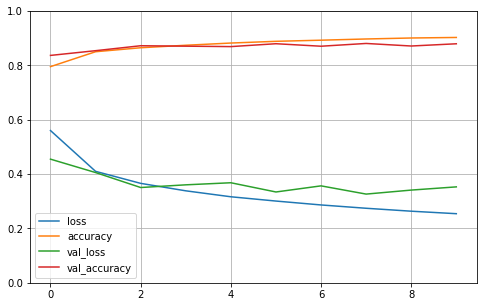

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1) # 显示坐标轴的范围
    plt.show()

plot_learning_curves(history)
# 1.参数众多，训练不充分
# 2.梯度消失：链式法则 --》复合函数f(g(x))求导
# 批归一化缓解ti'du'xi

In [ ]:
model.evaluate(x_test_scaled, y_test)